In [25]:
from __future__ import print_function, division, absolute_import

import gc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy as onp
import jax.numpy as np
import jax.nn
from jax import grad, jit, vmap
from jax import random

from jax.experimental import stax # neural network library
from jax.experimental.stax import Dense, Relu # neural network layers
from jax.experimental import optimizers
from jax.nn.initializers import glorot_normal, normal

In [26]:
from sklearn.datasets import make_moons
x_train, y_train = make_moons(n_samples = 5000, noise = 0.10)
x_test, y_test = make_moons(n_samples = 2000, noise = 0.10)
y_test = y_test.astype(np.float32)
y_train = y_train.astype(np.float32)

In [58]:
def ConcreteDropoutDense(out_dim, W_init=glorot_normal(), b_init=normal(), wd = 1e-8/10e3, dd = 2./10e3):
    def init_fun(rng, input_shape):
        if isinstance(input_shape[-1], tuple) and len(input_shape[-1]) == 0:
            input_shape = input_shape[0]
        output_shape = input_shape[:-1] + (out_dim,)
        k1, k2, k3 = random.split(rng, num = 3)
        W, b = W_init(k1, (input_shape[-1], out_dim)), b_init(k2, (out_dim,))
        init_min = 0.1
        init_max = 0.1
        init_min = onp.log(init_min) - onp.log(1. - init_min)
        init_max = onp.log(init_max) - onp.log(1. - init_max)
        p_logit = random.uniform(k3, shape = (), minval = init_min, maxval = init_max)
        return (output_shape, ()), (W, b, p_logit)
    def concrete_dropout(params, x, **kwargs):
        rng = kwargs.get('rng', None)
        w, b, p_logit = params

        eps = 1e-8
        temp = 0.1

        unif_noise = random.uniform(rng, shape = x.shape)
        p = 1.0/(1.0+np.exp(-p_logit))

        kernel_regularizer = wd * np.sum(np.square(w)) / (1. - p)
        dropout_regularizer = p * np.log(p)
        dropout_regularizer += (1. - p) * np.log(1. - p)
        dropout_regularizer *= dd * w.shape[-1]
        reg = np.sum(kernel_regularizer + dropout_regularizer)

        drop_prob = (
                    np.log(p + eps)
                    - np.log(1. - p + eps)
                    + np.log(unif_noise + eps)
                    - np.log(1. - unif_noise + eps)
        )
        drop_prob = 1.0/(1.0+np.exp(-(drop_prob / temp)))
        random_tensor = 1. - drop_prob

        retain_prob = 1. - p
        x *= random_tensor
        x /= retain_prob

        return x, reg
    def apply_fun(params, inputs, **kwargs):
        rng = kwargs.get('rng', None)
        if rng is None:
            msg = ("Dropout layer requires apply_fun to be called with a PRNG key "
                   "argument. That is, instead of `apply_fun(params, inputs)`, call "
                   "it like `apply_fun(params, inputs, key)` where `key` is a "
                   "jax.random.PRNGKey value.")
            raise ValueError(msg)
        W, b, p_logit = params
        reg_old = 0.
        x = inputs
        if isinstance(inputs, tuple):
            x, reg_old = inputs
        x, reg = concrete_dropout(params, x, rng = rng)
        return np.dot(x, W) + b, (reg + reg_old)
    return init_fun, apply_fun

def RegElementwise(fun, **fun_kwargs):
    """Layer that applies a scalar function elementwise on its inputs."""
    init_fun = lambda rng, input_shape: (input_shape, ())
    apply_fun = lambda params, inputs, **kwargs: (fun(inputs[0], **fun_kwargs), inputs[1])
    return init_fun, apply_fun
RegRelu = RegElementwise(jax.nn.relu)

In [63]:
def makeModel(x_train, y_train):
    train_size = len(x_train)
    lengthscale = 1e-4
    wd = lengthscale**2/train_size
    dd = 2./train_size
    L = x_train.shape[1]

    net_init, net_apply = stax.serial(
        ConcreteDropoutDense(100, wd = wd, dd = dd), RegRelu,
        ConcreteDropoutDense(50, wd = wd, dd = dd), RegRelu,
        ConcreteDropoutDense(5, wd = wd, dd = dd), RegRelu,
        ConcreteDropoutDense(1, wd = wd, dd = dd),
    )
    out_shape, params = net_init(random.PRNGKey(0), (-1, L))
    
    # Make a batched version of the `predict` function
    #batch_net_apply = vmap(net_apply, in_axes=(None, 0), out_axes=(None, None))

    def RegLoss(params, x, y, rng):
        y_pred, reg = net_apply(params, x, rng = rng)
        return np.mean(np.power(y - y_pred[:,0], 2)) + np.mean(reg)
    jit_RegLoss = jit(RegLoss)
    def RegMse(params, x, y, rng):
        y_pred, reg = net_apply(params, x, rng =rng)
        return np.mean(np.power(y - y_pred[:,0], 2))
    jit_RegMse = jit(RegMse)
    def RegMae(params, x, y, rng):
        y_pred, reg = net_apply(params, x, rng = rng)
        return np.mean(np.abs(y - y_pred[:,0]))
    jit_RegMae = jit(RegMae)
    def RegReg(params, x, y, rng):
        y_pred, reg = net_apply(params, x, rng = rng)
        return np.mean(reg)
    jit_RegReg = jit(RegReg)

    # Define a compiled update step
    @jit
    def step(i, opt_state, x1, y1, rng):
        p = get_params(opt_state)
        g = grad(RegLoss)(p, x1, y1, rng)
        return opt_update(i, g, opt_state)

    rng = random.PRNGKey(0)
    batch_size = 20
    Nepochs = 500
    opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)
    opt_state = opt_init(params)
    history = onp.zeros( (Nepochs, 4))
    for e in range(Nepochs):
        p = onp.random.permutation(train_size)
        Nbatches = int(train_size/batch_size)
        loss_ = 0
        mse_ = 0
        mae_ = 0
        reg_ = 0
        for i in range(Nbatches):
            rng, old = random.split(rng)
            x_b = x_train[p[i*batch_size:(i+1)*batch_size],:]
            y_b = y_train[p[i*batch_size:(i+1)*batch_size]]
            opt_state = step(i, opt_state, x_b, y_b, rng)
            loss_ += jit_RegLoss(get_params(opt_state), x_b, y_b, rng)
            mse_ += jit_RegMse(get_params(opt_state), x_b, y_b, rng)
            mae_ += jit_RegMae(get_params(opt_state), x_b, y_b, rng)
            reg_ += jit_RegReg(get_params(opt_state), x_b, y_b, rng)
            print("Epoch {:3d}, batch {:3d}/{:3d}: loss = {:>5.4f}, mse = {:>5.4f}, mae = {:>5.4f}, reg = {:>5.4f}".format(e, i, Nbatches,
                                            loss_/float(i+1), mse_/float(i+1), mae_/float(i+1), reg_/float(i+1)), end='\r')
        loss_ /= float(Nbatches)
        mse_ /= float(Nbatches)
        mae_ /= float(Nbatches)
        reg_ /= float(Nbatches)

        history[e,0] = loss_
        history[e,1] = reg_
        history[e,2] = mse_
        history[e,3] = mae_
        print("Epoch {:3d}: loss = {:>5.4f}, mse = {:>5.4f}, mae = {:>5.4f}, reg = {:>5.4f} ".format(e, loss_, mse_, mae_, reg_))
    print()
    params = get_params(opt_state)
    return net_apply, params, history



Epoch   0: loss = 0.0877, mse = 0.1078, mae = 0.2221, reg = -0.0201  reg = -0.0201
Epoch   1: loss = 0.0469, mse = 0.0666, mae = 0.1682, reg = -0.0197  reg = -0.0197
Epoch   2: loss = 0.0384, mse = 0.0579, mae = 0.1554, reg = -0.0195  reg = -0.0195
Epoch   3: loss = 0.0332, mse = 0.0526, mae = 0.1456, reg = -0.0194  reg = -0.0194
Epoch   4: loss = 0.0348, mse = 0.0541, mae = 0.1444, reg = -0.0193  reg = -0.0193
Epoch   5: loss = 0.0303, mse = 0.0496, mae = 0.1372, reg = -0.0193  reg = -0.0193
Epoch   6: loss = 0.0282, mse = 0.0474, mae = 0.1313, reg = -0.0193  reg = -0.01933
Epoch   7: loss = 0.0266, mse = 0.0458, mae = 0.1270, reg = -0.0192  reg = -0.0192
Epoch   8: loss = 0.0238, mse = 0.0430, mae = 0.1213, reg = -0.0192  reg = -0.01922
Epoch   9: loss = 0.0239, mse = 0.0431, mae = 0.1213, reg = -0.0192  reg = -0.0192
Epoch  10: loss = 0.0222, mse = 0.0414, mae = 0.1176, reg = -0.0192  reg = -0.01922
Epoch  11: loss = 0.0193, mse = 0.0386, mae = 0.1107, reg = -0.0193  reg = -0.0193
E

Epoch  97: loss = -0.0020, mse = 0.0187, mae = 0.0474, reg = -0.0207  reg = -0.0207
Epoch  98: loss = -0.0013, mse = 0.0194, mae = 0.0478, reg = -0.0207  reg = -0.0207
Epoch  99: loss = -0.0014, mse = 0.0193, mae = 0.0470, reg = -0.0206  reg = -0.0206
Epoch 100: loss = -0.0053, mse = 0.0153, mae = 0.0400, reg = -0.0206  reg = -0.0206
Epoch 101: loss = -0.0031, mse = 0.0174, mae = 0.0440, reg = -0.0205  reg = -0.0205
Epoch 102: loss = -0.0045, mse = 0.0160, mae = 0.0410, reg = -0.0205  reg = -0.0205
Epoch 103: loss = -0.0015, mse = 0.0189, mae = 0.0466, reg = -0.0204  reg = -0.0204
Epoch 104: loss = -0.0070, mse = 0.0134, mae = 0.0366, reg = -0.0204  reg = -0.0204
Epoch 105: loss = -0.0032, mse = 0.0172, mae = 0.0416, reg = -0.0204  reg = -0.0204
Epoch 106: loss = -0.0041, mse = 0.0163, mae = 0.0415, reg = -0.0204  reg = -0.0204
Epoch 107: loss = -0.0057, mse = 0.0147, mae = 0.0395, reg = -0.0204  reg = -0.0204
Epoch 108: loss = -0.0062, mse = 0.0142, mae = 0.0378, reg = -0.0204  reg = 

Epoch 194: loss = -0.0084, mse = 0.0104, mae = 0.0242, reg = -0.0188  reg = -0.0188
Epoch 195: loss = -0.0093, mse = 0.0095, mae = 0.0236, reg = -0.0188  reg = -0.0188
Epoch 196: loss = -0.0060, mse = 0.0127, mae = 0.0279, reg = -0.0187  reg = -0.0187
Epoch 197: loss = -0.0079, mse = 0.0108, mae = 0.0274, reg = -0.0187  reg = -0.0187
Epoch 198: loss = -0.0096, mse = 0.0091, mae = 0.0224, reg = -0.0187  reg = -0.0187
Epoch 199: loss = -0.0098, mse = 0.0089, mae = 0.0213, reg = -0.0187  reg = -0.0187
Epoch 200: loss = -0.0065, mse = 0.0122, mae = 0.0283, reg = -0.0187  reg = -0.0187
Epoch 201: loss = -0.0100, mse = 0.0087, mae = 0.0226, reg = -0.0187  reg = -0.0187
Epoch 202: loss = -0.0072, mse = 0.0115, mae = 0.0270, reg = -0.0187  reg = -0.0187
Epoch 203: loss = -0.0080, mse = 0.0107, mae = 0.0256, reg = -0.0187  reg = -0.0187
Epoch 204: loss = -0.0082, mse = 0.0104, mae = 0.0249, reg = -0.0187  reg = -0.0187
Epoch 205: loss = -0.0077, mse = 0.0110, mae = 0.0271, reg = -0.0187  reg = 

Epoch 291: loss = -0.0100, mse = 0.0080, mae = 0.0198, reg = -0.0180  reg = -0.0180
Epoch 292: loss = -0.0086, mse = 0.0095, mae = 0.0222, reg = -0.0180  reg = -0.0180
Epoch 293: loss = -0.0113, mse = 0.0068, mae = 0.0174, reg = -0.0181  reg = -0.0181
Epoch 294: loss = -0.0105, mse = 0.0075, mae = 0.0185, reg = -0.0181  reg = -0.0181
Epoch 295: loss = -0.0116, mse = 0.0064, mae = 0.0170, reg = -0.0180  reg = -0.0180
Epoch 296: loss = -0.0094, mse = 0.0086, mae = 0.0208, reg = -0.0180  reg = -0.0180
Epoch 297: loss = -0.0103, mse = 0.0077, mae = 0.0187, reg = -0.0180  reg = -0.0180
Epoch 298: loss = -0.0107, mse = 0.0073, mae = 0.0182, reg = -0.0180  reg = -0.0180
Epoch 299: loss = -0.0104, mse = 0.0076, mae = 0.0189, reg = -0.0180  reg = -0.0180
Epoch 300: loss = -0.0118, mse = 0.0062, mae = 0.0165, reg = -0.0180  reg = -0.0180
Epoch 301: loss = -0.0108, mse = 0.0073, mae = 0.0176, reg = -0.0181  reg = -0.0181
Epoch 302: loss = -0.0098, mse = 0.0083, mae = 0.0188, reg = -0.0181  reg = 

Epoch 388: loss = -0.0102, mse = 0.0077, mae = 0.0182, reg = -0.0179  reg = -0.0179
Epoch 389: loss = -0.0113, mse = 0.0066, mae = 0.0169, reg = -0.0179  reg = -0.0179
Epoch 390: loss = -0.0093, mse = 0.0086, mae = 0.0195, reg = -0.0179  reg = -0.0179
Epoch 391: loss = -0.0103, mse = 0.0075, mae = 0.0180, reg = -0.0179  reg = -0.0179
Epoch 392: loss = -0.0111, mse = 0.0067, mae = 0.0160, reg = -0.0178  reg = -0.0178
Epoch 393: loss = -0.0116, mse = 0.0062, mae = 0.0164, reg = -0.0178  reg = -0.0178
Epoch 394: loss = -0.0116, mse = 0.0062, mae = 0.0154, reg = -0.0178  reg = -0.0178
Epoch 395: loss = -0.0116, mse = 0.0062, mae = 0.0155, reg = -0.0178  reg = -0.0178
Epoch 396: loss = -0.0106, mse = 0.0072, mae = 0.0175, reg = -0.0178  reg = -0.0178
Epoch 397: loss = -0.0129, mse = 0.0049, mae = 0.0147, reg = -0.0178  reg = -0.0178
Epoch 398: loss = -0.0111, mse = 0.0067, mae = 0.0161, reg = -0.0178  reg = -0.0178
Epoch 399: loss = -0.0117, mse = 0.0060, mae = 0.0145, reg = -0.0177  reg = 

Epoch 485: loss = -0.0116, mse = 0.0059, mae = 0.0142, reg = -0.0175  reg = -0.0175
Epoch 486: loss = -0.0122, mse = 0.0053, mae = 0.0130, reg = -0.0175  reg = -0.0175
Epoch 487: loss = -0.0117, mse = 0.0058, mae = 0.0138, reg = -0.0175  reg = -0.0175
Epoch 488: loss = -0.0127, mse = 0.0047, mae = 0.0133, reg = -0.0175  reg = -0.0175
Epoch 489: loss = -0.0112, mse = 0.0063, mae = 0.0142, reg = -0.0175  reg = -0.0175
Epoch 490: loss = -0.0120, mse = 0.0055, mae = 0.0135, reg = -0.0175  reg = -0.0175
Epoch 491: loss = -0.0125, mse = 0.0050, mae = 0.0127, reg = -0.0175  reg = -0.0175
Epoch 492: loss = -0.0108, mse = 0.0067, mae = 0.0158, reg = -0.0175  reg = -0.0175
Epoch 493: loss = -0.0129, mse = 0.0046, mae = 0.0130, reg = -0.0175  reg = -0.0175
Epoch 494: loss = -0.0117, mse = 0.0058, mae = 0.0144, reg = -0.0175  reg = -0.0175
Epoch 495: loss = -0.0115, mse = 0.0060, mae = 0.0150, reg = -0.0175  reg = -0.0175
Epoch 496: loss = -0.0125, mse = 0.0050, mae = 0.0130, reg = -0.0175  reg = 

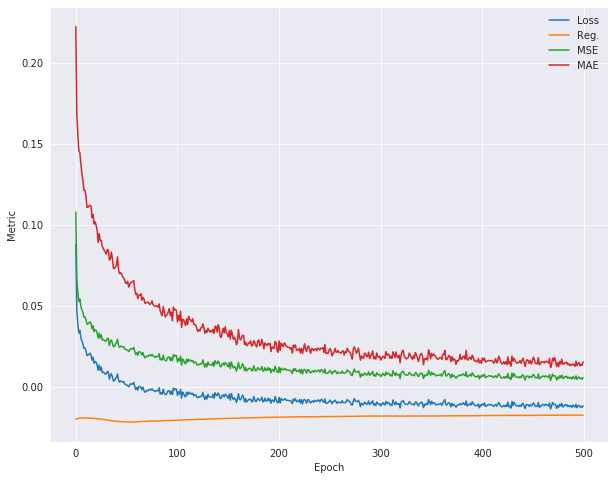

In [60]:
predict, params, history = makeModel(x_train, y_train)

fig = plt.figure(figsize = (10, 8))
plt.plot(range(len(history)), history[:,0], label = 'Loss')
plt.plot(range(len(history)), history[:,1], label = 'Reg.')
plt.plot(range(len(history)), history[:,2], label = 'MSE')
plt.plot(range(len(history)), history[:,3], label = 'MAE')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend(frameon = False)
plt.show()

In [64]:
def getMeanStd(predict, params, x, rand_key, Npred = 50):
    # per-example predictions
    p = [None]*Npred
    for k in range(Npred):
        rand_key, old = random.split(rand_key)
        p[k] = predict(params, x, rng = rand_key)[0][np.newaxis,...]
    p = np.concatenate(p, axis = 0)
    return np.mean(p, axis = 0), np.std(p, axis = 0)

In [65]:
def plot_contour(predict, params, x, y, getFunction):
    # make countour
    mins = [onp.min(x[:,0]), onp.min(x[:,1])]
    maxs = [onp.max(x[:,0]), onp.max(x[:,1])]
    step = [(maxs[0] - mins[0])/50.0, (maxs[1] - mins[1])/50.0]
    bx, by = onp.mgrid[mins[0]:(maxs[0]+0.5*step[0]):step[0], mins[1]:(maxs[1]+0.5*step[0]):step[1]]
    inputs = onp.vstack([bx.flatten(), by.flatten()]).T
    inputs = inputs.astype(onp.float32)

    rand_key = random.PRNGKey(0)

    pred_m, pred_s = getFunction(predict, params, inputs, rand_key, Npred = 50)
    pred_m_2d = pred_m.reshape( (-1, bx.shape[1]) )
    pred_s_2d = pred_s.reshape( (-1, bx.shape[1]) )

    # if one wants to smoothen the results
    #for data in [pred_m_2d, pred_s_2d]:
    #    data = gaussian_filter(data, 0.1)

    fig, ax = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (10, 8))
    cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
    contour_s = ax[0].contourf(bx, by, pred_s_2d, cmap = cmap)
    cbar_s = plt.colorbar(contour_s, ax = ax[0])
    cbar_s.ax.set_ylabel('Unc.')
    contour_m = ax[1].contourf(bx, by, pred_m_2d, cmap = cmap)
    cbar_m = plt.colorbar(contour_m, ax = ax[1])
    cbar_m.ax.set_ylabel('Mean')
    for a in [ax[0], ax[1]]:
        a.scatter(x[y == 1,0], x[y == 1,1], color = 'r', marker = 's', s = 5, label = 'y = 1')
        a.scatter(x[y == 0,0], x[y == 0,1], color = 'b', marker = 's', s = 5, label = 'y = 0')
        a.set(xlabel = 'A', ylabel = 'B', title = '')
        a.set_xlim([mins[0], maxs[0]])
        a.set_ylim([mins[1], maxs[1]])
        a.legend(frameon = True)
    ax[0].set_xlabel('')
    fig.subplots_adjust(hspace = 0)
    fig.tight_layout()
    plt.show()


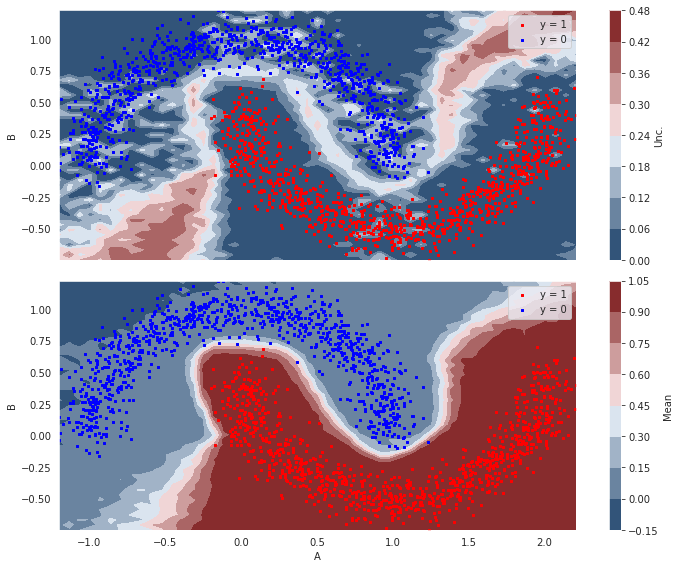

In [66]:
plot_contour(predict, params, x_test, y_test, getFunction = getMeanStd)